**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

* <h4>Física Teórica 3</h4> 
* <h4>1er cuatrimestre 2024</h4> 
* <h4>Grupo 3: Arcuschin Moreno Nicolas, Borrell Trinidad, Brusco Agustin, Martínez Garbino Paula</h4> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit, prange
from scipy.optimize import curve_fit
from scipy import stats
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

COLOR = "black"
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["figure.dpi"] = 50
plt.rcParams["figure.figsize"] = (28, 18)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams["figure.dpi"] = 50
plt.rcParams["axes.grid"] = True
# plt.rcParams["axes.facecolor"] = "lightgray"  # Disgusting -Agus. :( -Arcus
plt.rcParams["legend.fontsize"] = 25
plt.rcParams["axes.titlesize"] = 60
plt.rcParams["axes.labelsize"] = 50
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20

plt.rcParams["axes.grid"] = True

plt.rcParams["text.color"] = COLOR
plt.rcParams["text.color"] = COLOR
plt.rcParams["axes.labelcolor"] = COLOR
plt.rcParams["xtick.color"] = COLOR
plt.rcParams["ytick.color"] = COLOR
plt.rcParams["grid.color"] = COLOR
plt.rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

## 0. Definiciones pre-simulación

A continuación definimos las siguientes funciones:

* **`h(S)`**: calcula la energía por partícula de la red en el estado $S$ asumiendo que no hay campo magnético externo, y considerando condiciones de contorno periodicas, es decir, devuelve $\frac{H(S)}{L^2}$ con $H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1})$.

* **`metropolis(S, prob)`**: aplica el logaritmo de metropolis al estado $S$ tantas veces como sitios tiene la red. Mediante la función **`calculate_dE(S0, i, j, S)`** calcula la diferencia de energía al modificar la proyección de espín en la posición $(i, j)$.

* **`calculate_dE(S0, i, j, S)`**: calcula como se modifica la energía de la red $S$ al cambiar la proyección del espín en la posición $(i, j)$ considerando que el Hamiltoniano únicamente acopla primeros vecinos de la red, por ende, esta diferencia dependerá unicamente de estos 5 valores (el del espín modificado y sus cuatro primeros vecinos). En particular dado $H(S)$, modificando $S_{ij}$, tenemos que $\Delta E = 2 S_{ij} (S_{i-1j} + S_{ij-1} + S_{i+1j} + S_{ij+1})$.

In [7]:
@njit
def h(S: np.ndarray) -> float:  # Calcula la energía de la red en el estado S
    H = 0
    for i in np.arange(S.shape[0]):
        for j in np.arange(S.shape[1]):
            H += -S[i, j] * (S[i - 1, j] + S[i, j - 1])
    return H / S.size  # Aca S.size ya nos dá la normalización por L^2


@njit
def calculate_dE(s0: int, i: int, j: int, S: np.ndarray) -> int:
    # xx s3 xx
    # s4 s0 s2
    # xx s1 xx
    L = S.shape[0]
    upper_i = (i + 1) % L  # Condición de periodicidad
    upper_j = (j + 1) % L  # Condición de periodicidad
    s1, s2, s3, s4 = S[upper_i, j], S[i, upper_j], S[i - 1, j], S[i, j - 1]
    return 2 * s0 * (s1 + s2 + s3 + s4)


@njit
def metropolis(S: np.ndarray, prob: np.ndarray) -> tuple[np.ndarray, float, float]:
    # Aplica el algoritmo de Metropolis al estado S
    dm = 0
    de = 0
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada
    # sitio en la red, es decir, L cuadrado veces.
    for _ in range(S.size):
        i, j = np.random.choice(S.shape[0], 2)  # Las coordenadas al azar en [0, L)²
        sij = S[i, j]  # El spin de esa posición
        opp_sij = -sij  # El spin al que podría transicionar
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía al transicionar de sij a opp_sij
        p = np.random.random(1)
        if (  # El spin cambia su estado si:
            dE_sij <= 0  # La diferencia de energía es negativa o cero
            or (dE_sij == 4 and p < prob[0])  # Con prob[0] si dE = 4
            or (dE_sij == 8 and p < prob[1])  # Con prob[1] si dE = 8
        ):
            S[i, j] = opp_sij  # El spin cambia de estado
            de += dE_sij
            dm += opp_sij
    return S, dm / S.size, de / S.size

## 1.1. Termalización y primera simulación

A continuación definimos la función **`termalize_S(S,prob)`** que garantiza la termalización del sistema, es decir, cuando los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para que se cumpla esta condición de forma genérica consideramos aplicar el algoritmo de metropolís hasta que el promedio de **`n_check`** consecutivos incrementos de la energía y de magnetización sean menores a $10^{-6}$. Allí entonces garantizamos que se hagan los pasos necesarios para decir que el valor de la energía y la magnetización oscilan alrededor de un valor.

In [8]:
@njit
def termalize_S(S, prob):
    n = 0
    n_check = 100
    historic_de = np.zeros(n_check)
    historic_dm = np.zeros(n_check)
    while True:
        S, dm, de = metropolis(S, prob)
        historic_de[n%n_check] = de
        historic_dm[n%n_check] = dm
        
        n+=1
        sum_de = np.sum(historic_de)
        sum_dm = np.sum(historic_dm)
        if n//n_check>0:
            if (np.abs(sum_de/(n_check)) < 1e-6) and (np.abs(sum_dm/n_check) < 1e-6):
                break        
    return S

A continuación lo chequeamos para una única simulación, donde llamamos a la función de termalización. Una vez hecho esto aplicamos el algoritmo de metropolis $15000$ veces o hasta que en se cumpla en $500$ pasos que la diferencia absoluta entre energias promedios consecutivas y magnetizaciones promedios consecutivas sean menores a $10^{-6}$

En esta lógica vamos a basar después nuestro estudio para tomar buenos promedios.

In [9]:
L = 64  # Dimensiones de la red
S = np.ones((L, L), dtype=int)
# S = 2*np.random.randint(2,size=(L,L))-1 # Red de -1y1 bidimensional
T = 1.75
beta = 1 / T
prob = np.exp(-beta * np.array([4, 8]))

S = termalize_S(S, prob)

N_max = 15_000
M = np.zeros(N_max)  # Magnetización en función del paso
E = np.zeros(N_max)  # Energía por particula en funcion del paso
M[0] = np.mean(S)  # Promedio de spines
E[0] = h(S)  # Energía por partícula

M_avg = np.zeros_like(M)  # M_avg[i] = mean(|M[:i+1]|)
E_avg = np.zeros_like(E)  # E_avg[i] = mean(E[:i+1])

M_avg[0] = abs(M[0])
E_avg[0] = E[0]

n = 1
average_counter = 0
while (n < N_max) and (average_counter < 500):
    S, dm, de = metropolis(S, prob)
    M[n] = M[n - 1] + dm
    E[n] = E[n - 1] + de
    M_avg[n] = np.mean(abs(M[:n+1]))
    E_avg[n] = np.mean(E[:n+1])
    # Si la diferencia absoluta entre este paso y el siguiente es menor a 10e-6 añado uno al contador de promedio
    # Si esto sucede 500 veces decimos que el sistema tiene un promedio estable
    if (abs(E_avg[n-1] - E_avg[n]) < 1e-6) and (abs(M_avg[n-1] - M_avg[n]) < 1e-6):
        average_counter += 1
    n += 1

Enn = E[:n]
Mnn = M[:n]
E_avg = E_avg[:n]
M_avg = M_avg[:n]

A continuación se observa el gráfico con el estudio correspondiente.

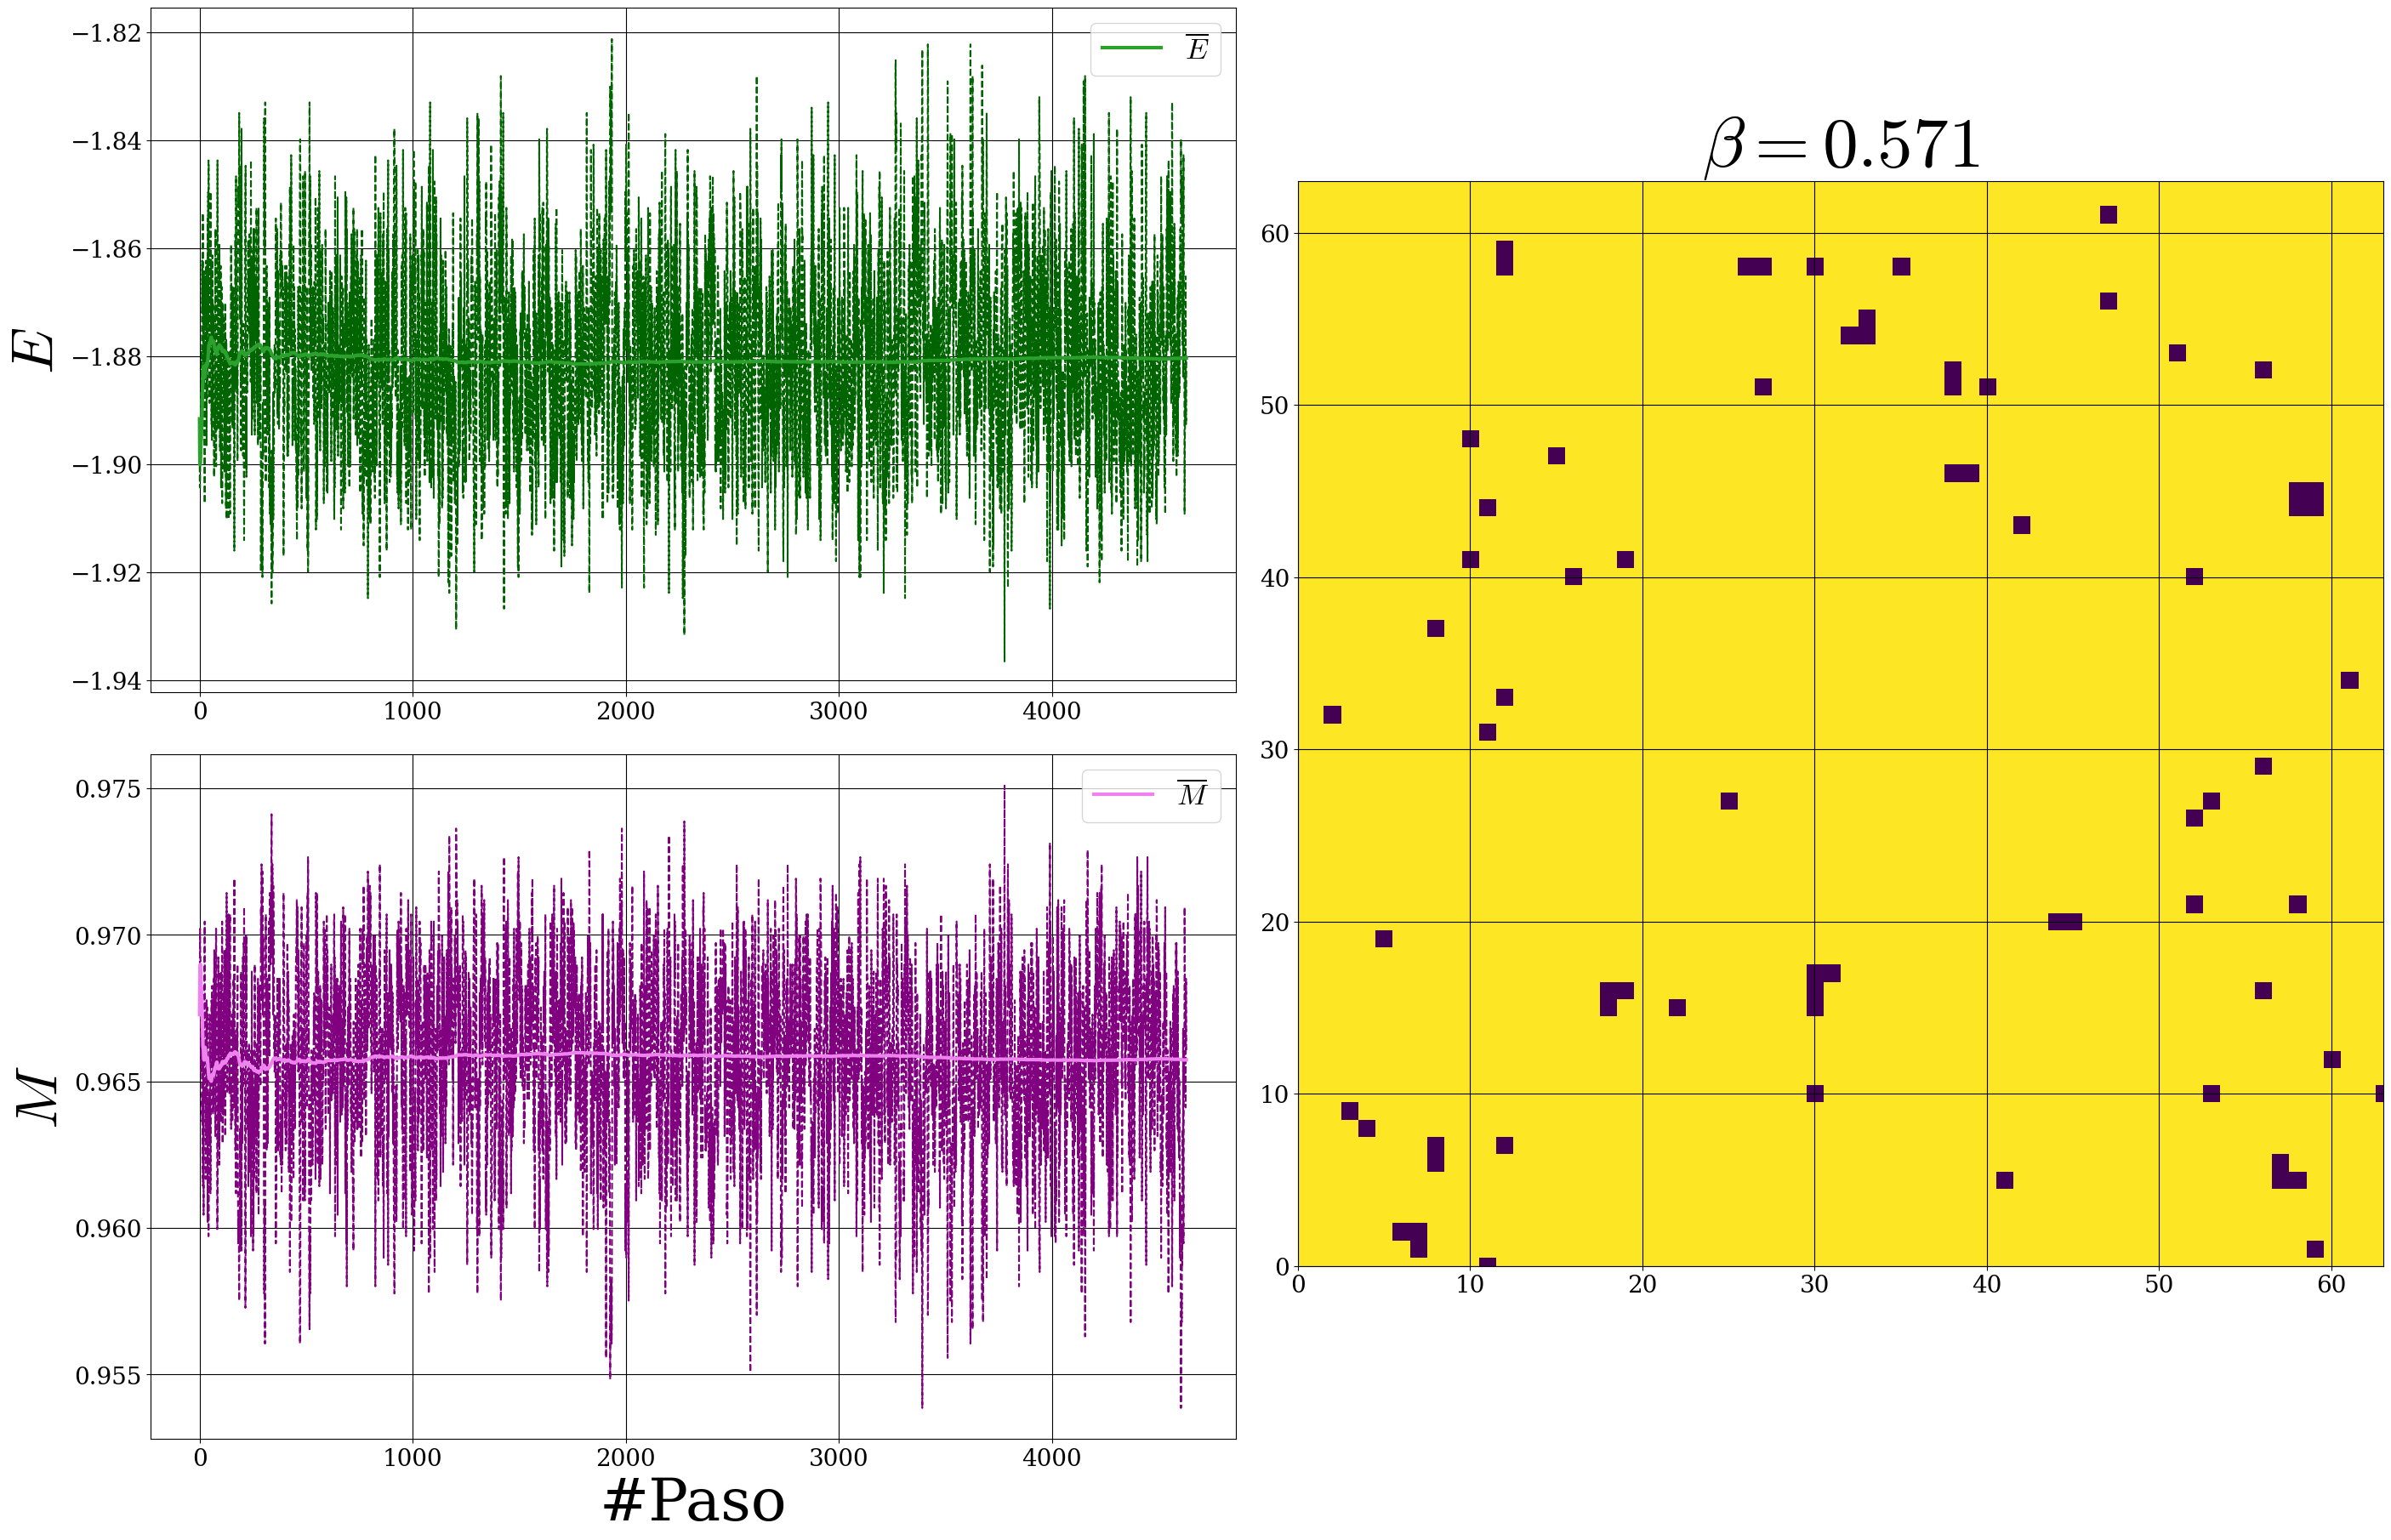

In [ ]:
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax_2d = fig.add_subplot(gs[:, 1])

ax1.plot(Enn, color="darkgreen", linestyle='--')
ax1.plot(E_avg, color="tab:green", label="$\overline{E}$", lw=3)

ax2.plot(Mnn, color="purple", linestyle='--')
ax2.plot(M_avg, color="violet", label="$\overline{M}$", lw=3)

ax_2d.imshow(S)

ax_2d.set_ylim(0, L - 1)
ax_2d.set_xlim((0, L - 1))


ax1.set_ylabel("$E$")
ax2.set_ylabel("$M$")
ax2.set_xlabel("#Paso")
ax_2d.set_title(rf"$\beta = {beta:.3g}$")

ax1.legend()
ax2.legend()
plt.show()

## 1.2. Promedios: estudio de las variaciones de los promedios en función de T y L

A continuación hicimos un estudio de las variaciones de los promedios, analizando los pasos necesarios para que el promedio sea lo suficiemntemente bueno. Para ello definimos las siguientes funciones:

* **`create_dense_domain_around_tc(temperatura_critica, n_puntos)`**: generamos un dominio de temperaturas con mayor densidad alrededor de la temperatura crítica. [DESARROLLAR]

* **`do_sim_until_convergence(S, prob)`**: nos devuelve el $n$ tal que los promedios son 'buenos' dada una red $S$. Usa la misma lógica del punto anterior donde se nos da una red $S$ termalizada y luego se aplica metropolis los $n$ pasos necesarios hasta que se cumpla que durante $500$ pasos la diferencia entre valores promedios sucesivos de energía y magnetización sean menores a $10^{-6}$. Para ese $n$ resultante podemos decir que el promedio es bueno.

* **`get_stable_ns_for_measurement(T_arr, S0)`**: esta función automatiza la obtención de pasos a dar para obtener buenos promedios para un arrglo de temperaturas. En primer lugar impone una condición inicial sobre la red $S$ (en general será matriz de unos para temperaturas bajas y matriz de valores randomizados para temperaturas altas. En esta condición inicial obtenemos la información del tamaño de la red) y la termaliza. Luego para cada temperatura obtiene el $n$ tal que el promedio es bueno llamando a la función **`do_sim_until_convergence(S, prob)`**. Finalmente devuelve el $n$ de cada temperatura en la lista **`n_promedios`**.

In [67]:
def create_dense_domain_around_tc(temperatura_critica: float, n_puntos: int):
    # # Define the range of the domain
    # x_min = temperatura_critica/2 + 0.5
    # x_max = temperatura_critica*2 - 0.5
    # # Define the density function (a Gaussian-like distribution)
    # def density_function(x, center, scale):
    #     return np.exp(-((x - center) ** 2) / (2 * scale ** 2))

    # # Generate x values
    # x_values = np.linspace(x_min, x_max, n_puntos)

    # # Compute the density values
    # scale = 0.5  # Adjust scale for desired density spread
    # density_values = density_function(x_values, temperatura_critica, scale)

    # # Normalize the density values
    # density_values /= np.sum(density_values)

    # # Create a cumulative distribution function (CDF) for the density values
    # cdf = np.cumsum(density_values)

    # # Generate the dense domain using the inverse CDF method
    # dense_domain = np.interp(np.linspace(0, 1, n_puntos), cdf, x_values)
    
    # Define the symmetry point
    distribucion = stats.norm(loc=temperatura_critica, scale=0.5)  # Gaussiana
    # Genero un array de valores equiespaciados entre 0 y 1 para samplear la ICDF
    base_domain = np.linspace(1, 0, n_puntos + 2)[1:-1]
    # Evaluo la ICDF en los valores generados
    dense_domain = distribucion.isf(base_domain)
    return dense_domain


@njit
def do_sim_until_convergence(S, prob):
    N_max = 50_000
    M = np.zeros(N_max)  # Magnetización en función del paso
    E = np.zeros(N_max)  # Energía por particula en funcion del paso
    M_avg = np.zeros_like(M)  # M_avg[i] = mean(|M[:i+1]|)
    E_avg = np.zeros_like(E)  # E_avg[i] = mean(E[:i+1])

    M[0] = np.sum(S) / S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula
    M_avg[0] = np.abs(M[0])
    E_avg[0] = E[0]

    n = 1
    average_counter = 0
    while (n < N_max) and (average_counter < 500):
    # for n in range(1, N_max):
        # if average_counter >= 500:
        #     break
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de
        M_avg[n] = np.mean(np.abs(M[:n+1]))
        E_avg[n] = np.mean(E[:n+1])
        # Si la diferencia absoluta entre este paso y el siguiente es menor a 10e-6
        # añado uno al contador de promedio
        # Si esto sucede 500 veces decimos que el sistema tiene un promedio estable
        if (abs(E_avg[n-1] - E_avg[n]) < 1e-6) and abs(M_avg[n-1] - M_avg[n] < 1e-6):
            # Podría mejorarse pidiendo algo con respecto al error relativo
            average_counter += 1
        n += 1
    return n


def get_stable_ns_for_measurement(T_arr: np.ndarray, S0):
    n_promedios = np.zeros_like(T_arr)
    for ti in tqdm(range(T_arr.size), desc="T", total=T_arr.size):
        T = T_arr[ti]
        beta = 1 / T
        prob = np.exp(-beta * np.array([4, 8]))
        if T < 2.27:
            S = S0[0]  # T bajas
        else:
            S = S0[1]  # T altas
        S = termalize_S(S, prob)
        n_promedios[ti] = do_sim_until_convergence(S, prob)
    return n_promedios

A continuación considerando $101$ valores de temperaturas y $6$ valores de tamaño de red se coniguieron la cantidad de pasos para obtener buenos promedios. El resultado se guardó en un 'csv' llamado 'LT_matrix.csv'.

In [69]:
T_arr = create_dense_domain_around_tc(2.27, 101)
L_arr = 2**np.arange(4, 9+1)  # 16, 32, 64, 128, 256, 512

# Calculamos para todos los L
try:
    df_0 = pd.read_csv("LT_matrix.csv", index_col=0, dtype=float)
    df_0.columns = [int(L_str) for L_str in df_0.columns]
    df_0 = df_0.map(int)
except FileNotFoundError:
    df_0 = pd.DataFrame(index=T_arr, columns=[*L_arr])
    for L in L_arr:
        # Definimos estados iniciales para S y los usamos luego en función de la
        # temperatura a la que queremos trabajar:
        print(f"Calculando para {L = }")
        S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L,L))-1]
        df_0[L] = get_stable_ns_for_measurement(T_arr, S0)
        print()

    df_0.to_csv('LT_matrix.csv')

# Calculamos de nuevos para los L más chicos que tienen mayor varianza
# y luego promediamos los resultados
try:
    df_1 = pd.read_csv("LT_matrix_1.csv", index_col=0, dtype=float)
    df_1.columns = [int(L_str) for L_str in df_1.columns]
    df_1 = df_1.map(int)
except FileNotFoundError:
    df_1 = pd.DataFrame(index=T_arr, columns=[*L_arr])
    for L in L_arr[:3]:
        # Definimos estados iniciales para S y los usamos luego en función de la
        # temperatura a la que queremos trabajar:
        print(f"Calculando para {L = }")
        S0 = [np.ones((L, L), dtype=int), 2 * np.random.randint(2, size=(L,L))-1]
        df_1[L] = get_stable_ns_for_measurement(T_arr, S0)
        print()

    df_1.to_csv('LT_matrix.csv')

# Promediamos los resultados repetidos
df_n = round((df_0 + df_1)/2)
df_n.fillna(df_0, inplace=True)
df_n = df_n.map(int)

In [154]:
# from scipy.interpolate import RegularGridInterpolator
# from scipy.interpolate import RectBivariateSpline

def get_n_from_matrix(L: int, T: float, df_n: pd.DataFrame) -> int:
    L_vals = df_n.columns.to_numpy()
    T_vals = df_n.index.to_numpy()
    N_grid = df_n.to_numpy()
    
    # Agarro el valor más cercano:
    # row_num = np.argmin(abs(T_vals - T))
    # col_num = np.argmin(abs(L_vals - L))
    # return int(N_grid[row_num, col_num])
    
    # Interpolamos:
    # interpolator = RegularGridInterpolator((L_vals, T_vals), N_grid.T, method="nearest",
    #                                        bounds_error=False, fill_value=None)
    # return np.round(interpolator((L, T)))
    
    # Interpolamos distinto:
    # interpolator = RectBivariateSpline(L_vals, T_vals, N_grid.T, ky=1, s=10)
    # return np.round(interpolator(L, T, ))
    
    row_num = np.argmin(abs(T_vals - T))
    col_num = np.argmin(abs(L_vals - L))
    n_vecinos = 10
    # Promedio a n vecinos en T
    N_medio = np.mean(N_grid[max(row_num-n_vecinos//2, 0):row_num+n_vecinos//2, col_num])
    return np.round(N_medio)

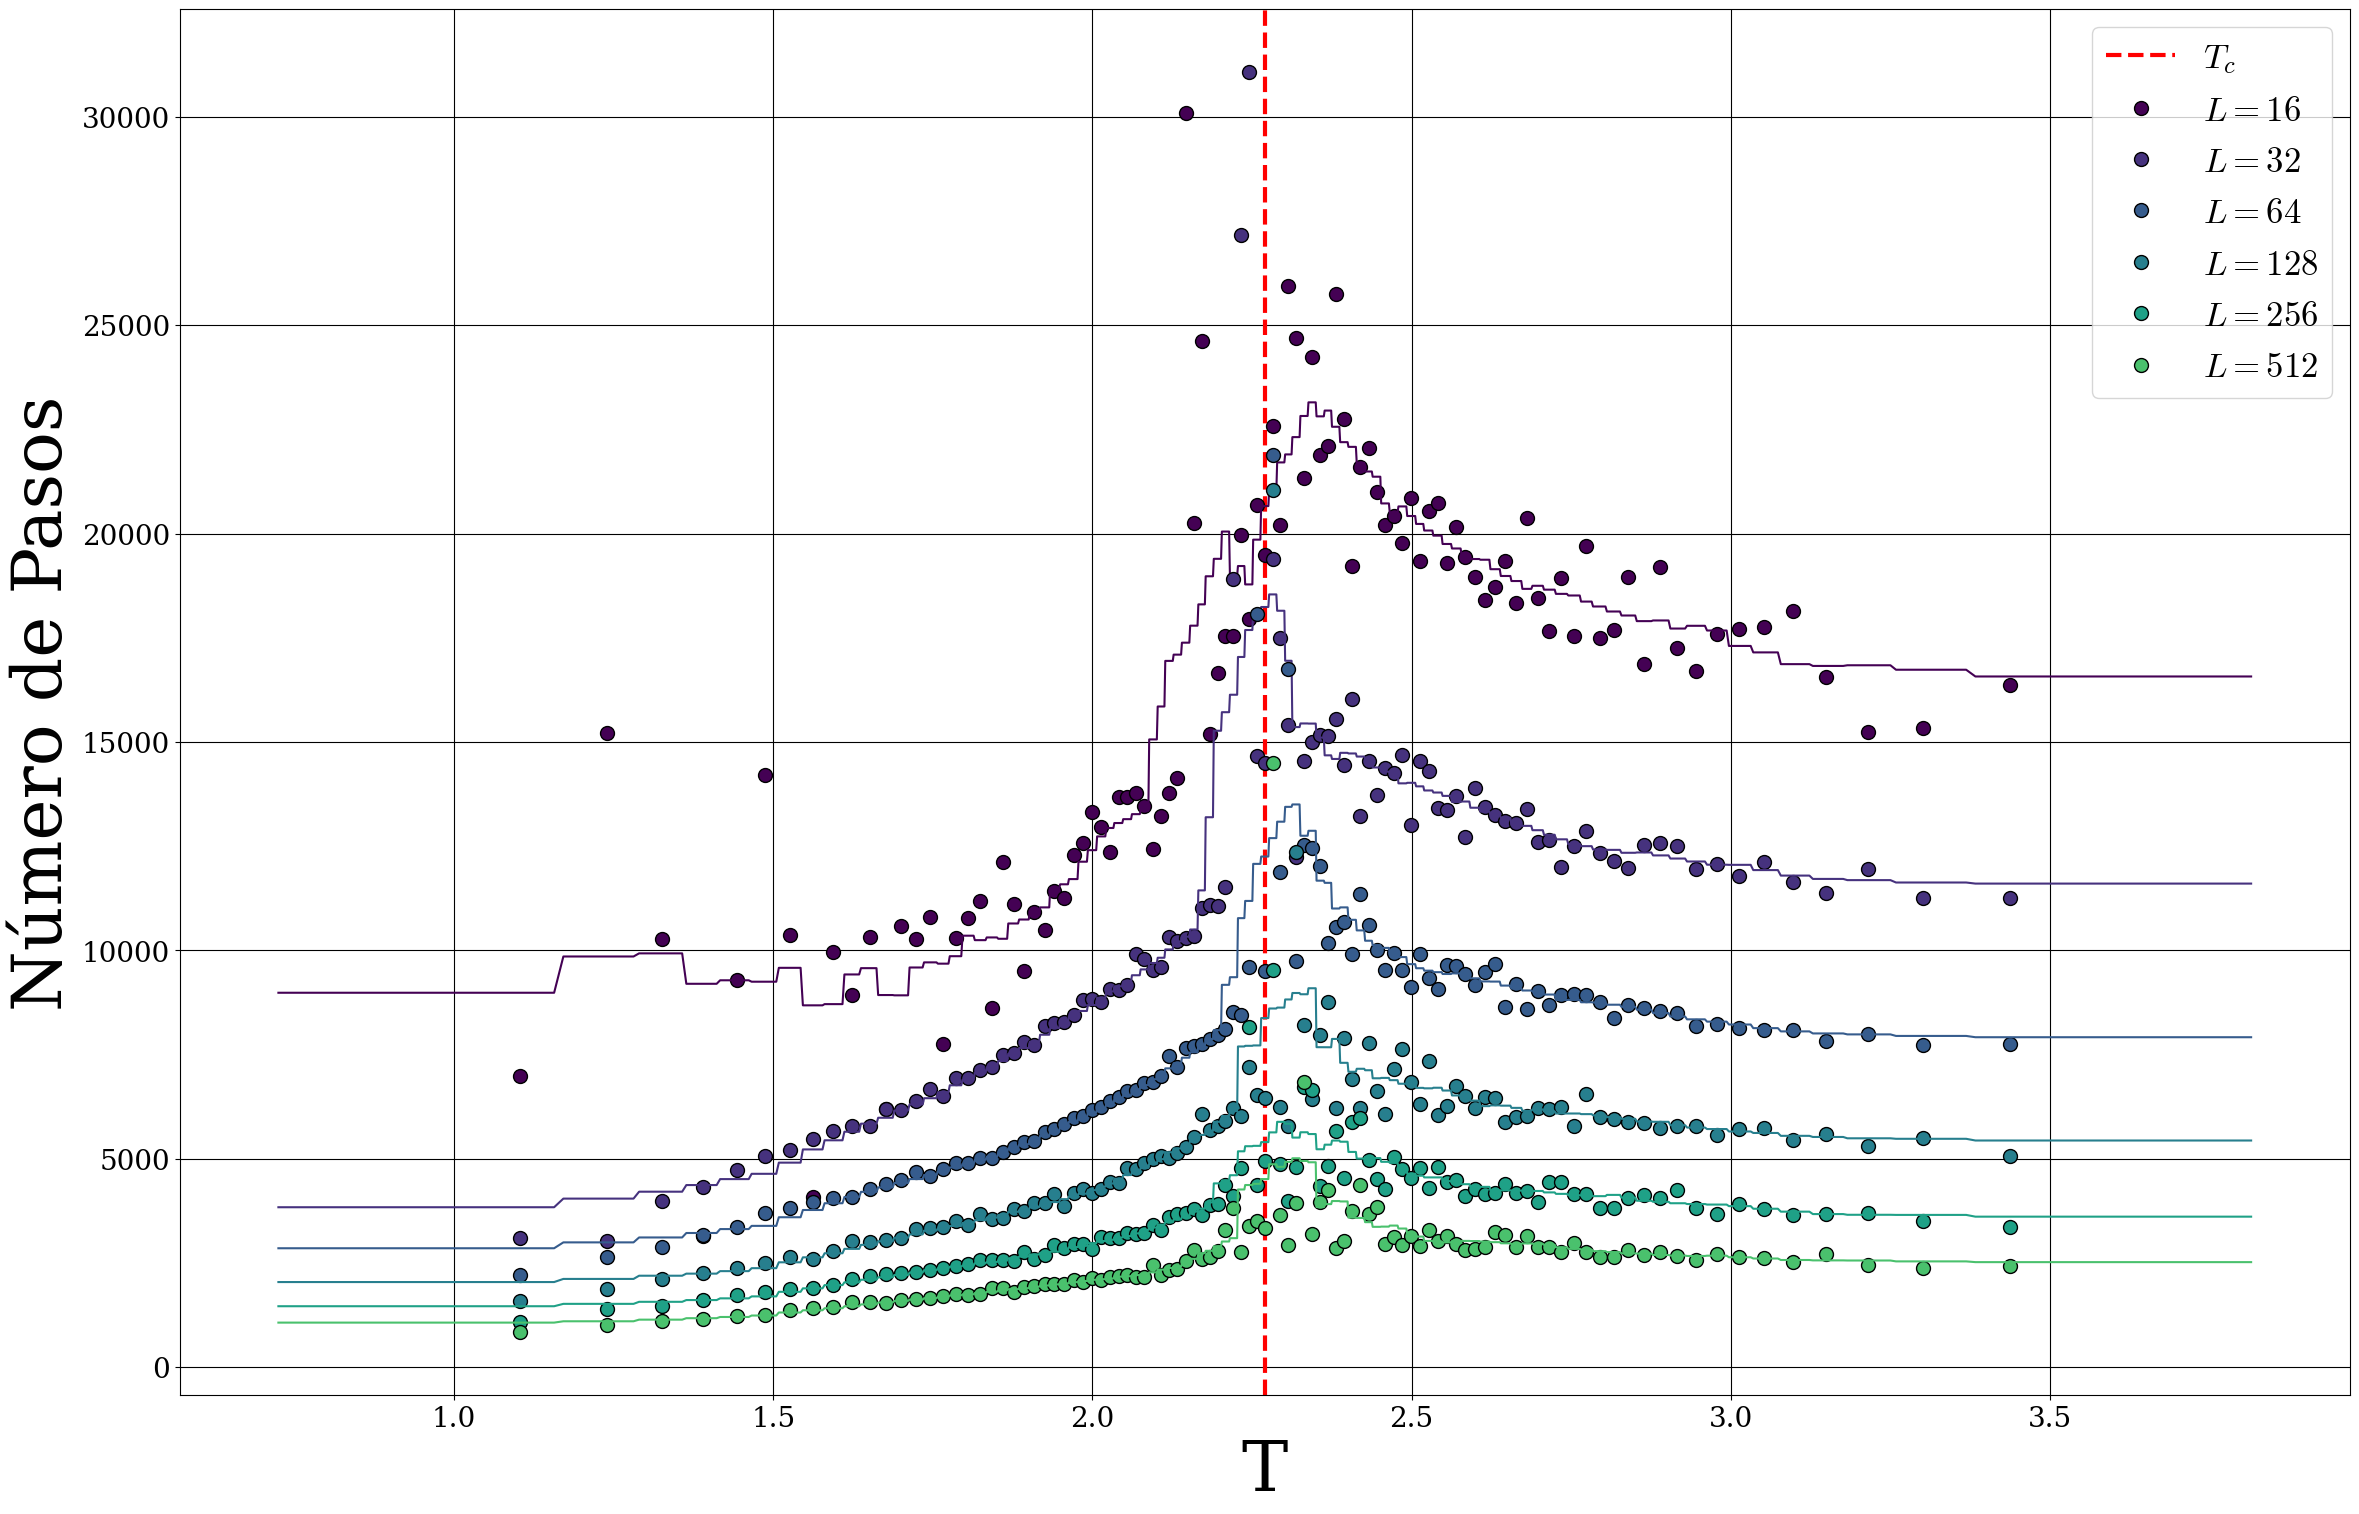

In [158]:
from matplotlib.colors import LogNorm

fig,ax = plt.subplots()
ax.axvline(2.27, color='r', ls='--', lw=3, label='$T_c$')
L_colors = cm.ScalarMappable(LogNorm(L_arr[0], L_arr[-1]*4), cmap="viridis")
T_dense = create_dense_domain_around_tc(2.27, 1000)
LT_matrix = df_n.to_numpy()
for li, L in enumerate(L_arr):
    ax.plot(
        T_arr, LT_matrix[:, li], 'o', ms=10, mec="k", mew=1, color=L_colors.to_rgba(L),
        label=f"${L = }$"
    )
    ax.plot(
        # T_dense, get_n_from_matrix(L, T_dense, df_n).flatten(), '-', color=L_colors.to_rgba(L)
        T_dense, [get_n_from_matrix(L, T, df_n) for T in T_dense], '-', color=L_colors.to_rgba(L)
    )
    # ax.text(
    #     T_arr[-3], LT_matrix[li, -3] - 200, f"{L = }",
    #     ha="left", va="top", size=40, color=L_colors.to_rgba(L),
    # )
    ax.set_ylabel('Número de Pasos')
    ax.set_xlabel('T')
ax.legend()
# ax.set_ylim(top=20_000)
# plt.colorbar(L_colors, ax=ax, ticks=L_arr, format="{x:.0f}", extend="both")
plt.show()

## 2. Transición de fase

A continuación, considerando los estudios previos, calculamos la energía media por partícula, la magnetización media, la suceptibilidad y el calor específico. La energía y magnetización media las calculamos tomando la media de estos valores sobre el sistema una vez que este termalizó y que se tomaron pasos suficientes para hacer un buen promedio. Por otro lado, la suceptibilidad y el calor específico los calculamos considerando la varianza de la energía y de la magnetización, utilizando las siguientes relaciones y que $k = 1$.

- $\langle \Delta E ^ 2 \rangle = T^2 N c_v$

- $\langle \Delta M ^ 2 \rangle = T N \chi$

Para ello usamos las funciones: 

* **`phase_transition(T, prob)`**: en esta función se termaliza una red $S$ y luego se aplica **`n_stable`** veces el algoritmo metropolis para obtener los promedios de energía y magnetización. Esto último se hace en la función **`doNstepsofSimulation(S, prob)`**, y la idea es que el valor de  **`n_stable`**  se base en el estudio previo hecho para tomar buenos promedios. Obtenemos la media y la varianza de la energía, la magnetización y la red resultante.

* **`doNstepsofSimulation(S, prob)`**: aplica el algoritmo de metropolis **`n_stable`** pasos.

In [23]:
@njit
def doNstepsofSimulation(S,N,prob):
    M = np.zeros(N)  # Magnetización en función del paso
    E = np.zeros(N)  # Energía por particula en funcion del paso
    M[0] = np.sum(S)/S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula

    for n in range(1, N):
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de

    return E,M

@njit
def phase_transition(T, n_stable, S0):
    beta = 1 / T
    dE = np.array([4, 8])  # únicos Delta_E positivos
    prob = np.exp(-beta * dE)

    #Termalizamos el sistema
    S = termalize_S(S0, prob)
    #Lo estabilizamos
    E, M = doNstepsofSimulation(S, n_stable, prob)
    # #Tomamos N muestras de la energía y la magnetización
    # E, M = doNstepsofSimulation(S, N, prob)
    
    avg_E = np.sum(E)/n_stable
    avg_M = np.sum(np.abs(M))/n_stable

    std_E = np.sqrt(np.sum((E - avg_E)**2)/(n_stable-1))
    std_M = np.sqrt(np.sum((np.abs(M) - avg_M)**2)/(n_stable-1))

    return avg_E, avg_M, std_E**2, std_M**2, S


A continuación observamos los resultados obtenidos para una red de dimensión $64$ x $64$. Usamos del punto previo la función que nos define un dominio con mayor densidad de puntos alrededor de la temperatura crítica y a su vez usando los valores obtenidos dado un valor de $T$ y $L$ para tomar buenos promedios.

In [51]:
L = 64  # Dimensiones de la red

T_arr = create_dense_domain_around_tc(2.27, 50)
mean_E_T = np.zeros(len(T_arr))
mean_M_T = np.zeros(len(T_arr))
var_E_T = np.zeros(len(T_arr))
var_M_T = np.zeros(len(T_arr))

In [52]:
T_threshold = 2.27

T = T_arr[0]
S0 = [np.ones((L, L), dtype=int), 2*np.random.randint(2,size=(L,L))-1]
if T < T_threshold:
    S = S0[0] #T bajas
else:
    S = S0[1] #T altas

for i, T in tqdm(enumerate(T_arr)):
    n_stable = int(pd.read_csv('LT_matrix.csv', index_col='Unnamed: 0')[str(L)].to_numpy()[i])
    mean_E, mean_M, var_E, var_M, S = phase_transition(T, n_stable, S)
    mean_E_T[i] = mean_E
    mean_M_T[i] = mean_M
    var_E_T[i] = var_E
    var_M_T[i] = var_M

0it [00:00, ?it/s]

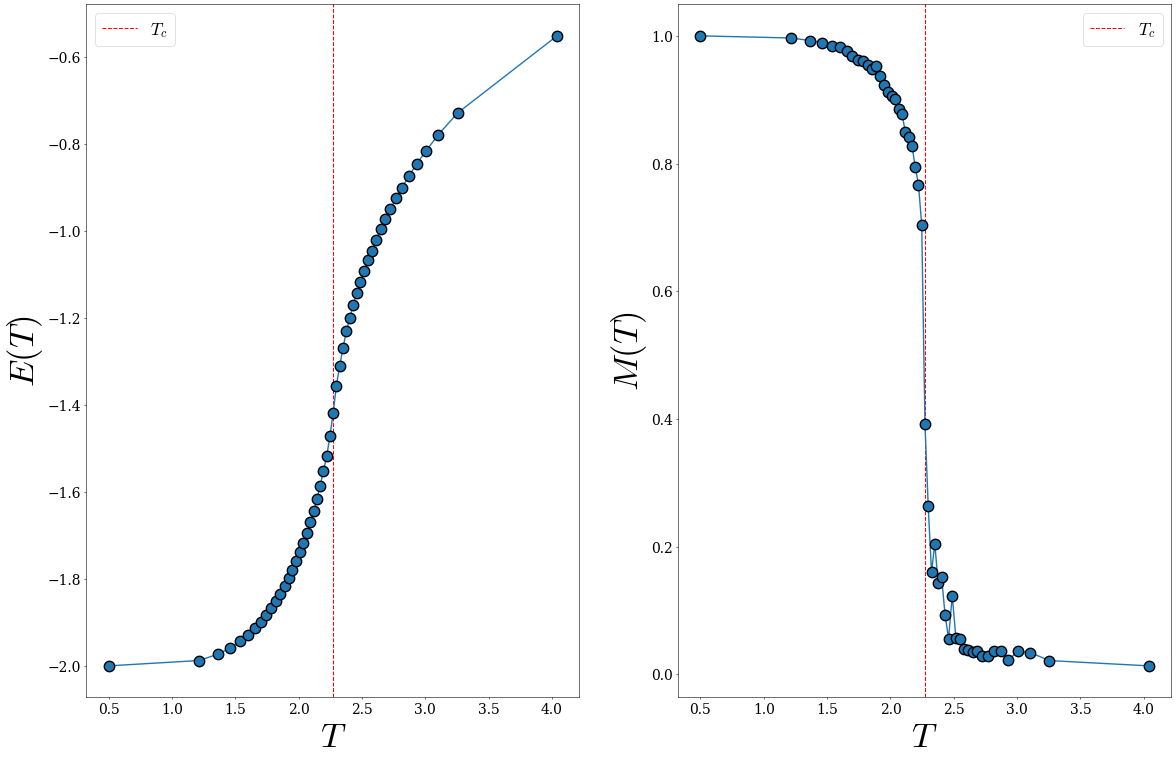

In [42]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_E_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$E(T)$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$M(T)$')
plt.grid()
plt.legend()
plt.show()

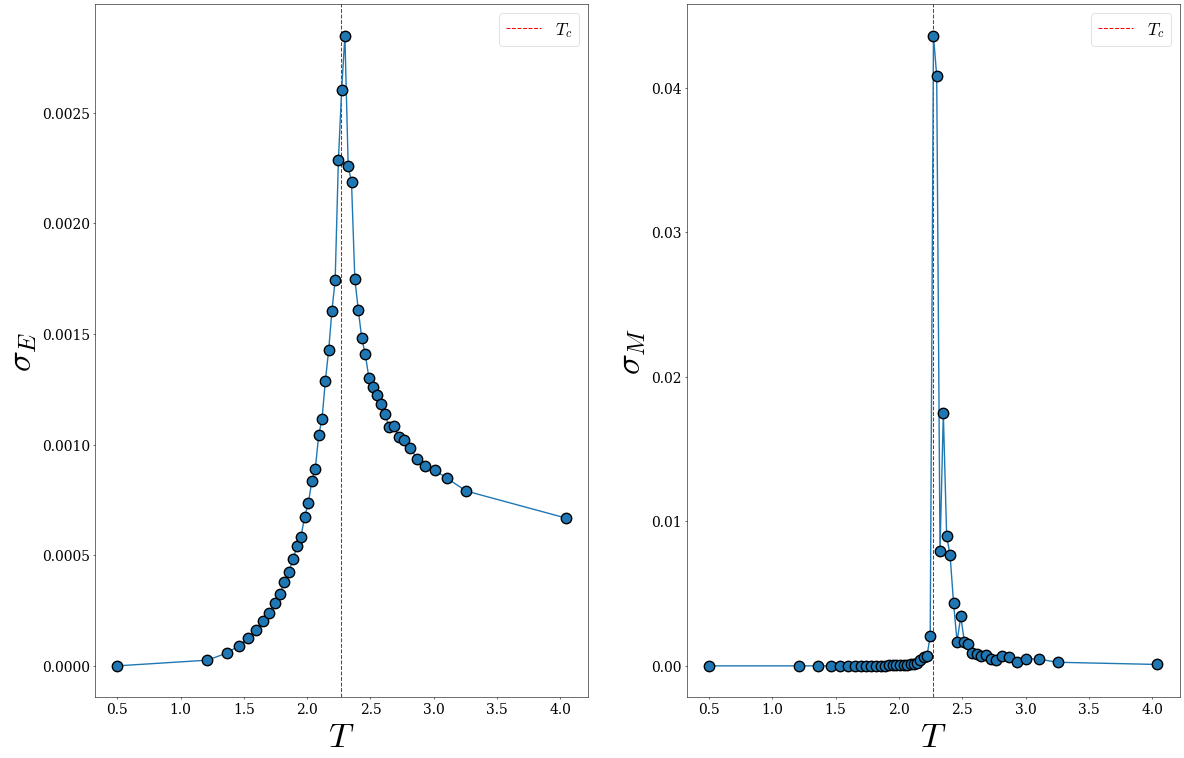

In [43]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$\sigma_E$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\sigma_M$')
plt.legend()
plt.grid()
plt.show()

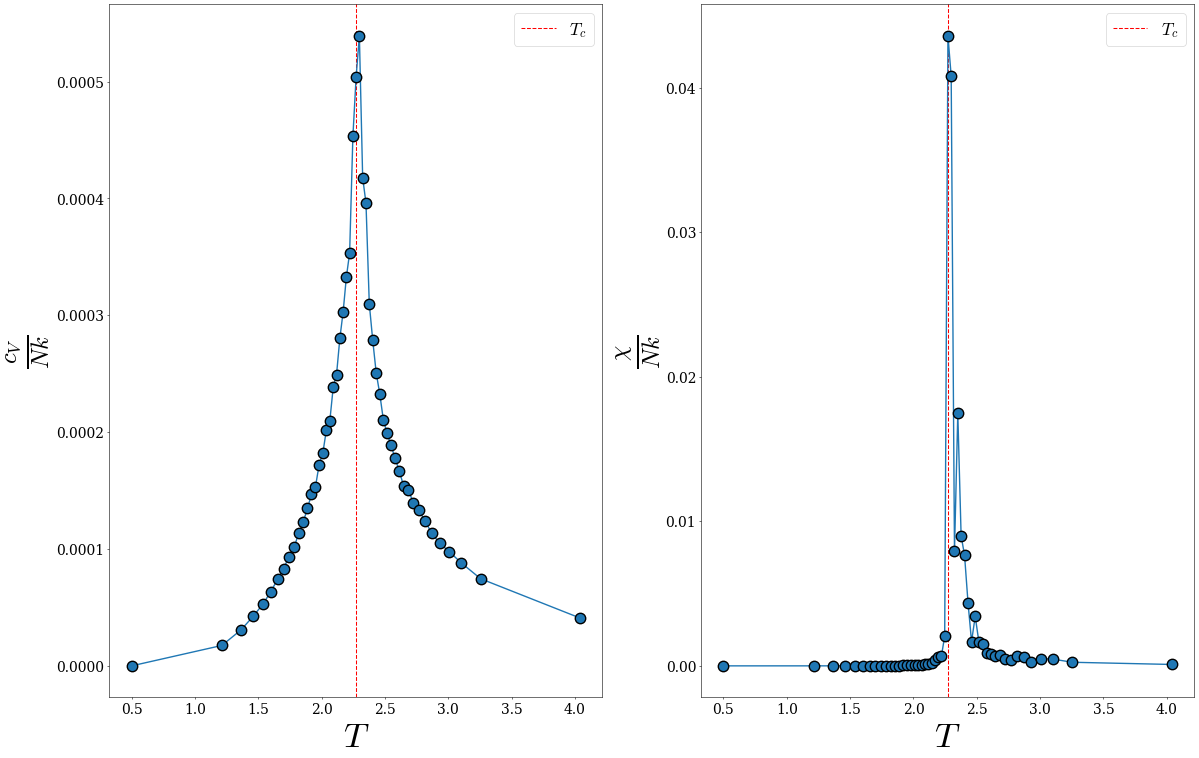

In [44]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T*(1/T_arr**2), 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{c_V}{N}$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{\chi}{N}$')
plt.grid()
plt.legend()
plt.show()

## 3. Correlaciones

In [23]:
@njit
def cor(S: np.ndarray) -> np.ndarray:
    L = S.shape[0]
    cor_vec = np.zeros(L // 2)
    for r, _ in enumerate(cor_vec):
        cor_filas = np.zeros(L)
        for i in prange(L):
            fila = S[i]
            fila_shift = np.roll(fila, r)
            cor_filas[i] = np.sum(fila * fila_shift)
        cor_vec[r] = np.sum(cor_filas)
    return cor_vec / (L**2)


@njit
def metropolis2(S: np.ndarray, prob: np.ndarray):
    # Aplica el algoritmo de Metropolis al estado S
    # if N == S.size:
    #    return S, h(S), np.mean(S)
    dm = 0
    dc = np.zeros(S.shape[0] // 2)
    for _ in range(S.size):
        i, j = np.random.choice(
            S.shape[0], 2
        )  # Elegimos 2 posiciones al azar en el rango [0,L)
        sij = S[i, j]  # Obtenemos el spin de esa posición
        opp_sij = -sij  # Obtenemos el spin opuesto al original
        # dE_sij = calculate_dE(opp_sij, i, j, S) - calculate_dE(
        #     sij, i, j, S
        # )
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía entre tener el spin opuesto y tener el actual
        p = np.random.random(1)
        c_viejo = cor(S)  # [Optim] Levantar de cuenta anterior?
        if (
            dE_sij <= 0
            or (dE_sij == 4 and p < prob[0])
            or (dE_sij == 8 and p < prob[1])
        ):
            S[i, j] = opp_sij
            dm += opp_sij
            dc += cor(S) - c_viejo  # [Optim] Se podría calcular la contribución especifica de este spin
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en
    # la red, es decir, L cuadrado veces.
    # return metropolis(S, prob, N + 1)
    return S, dm / S.size, dc / S.size

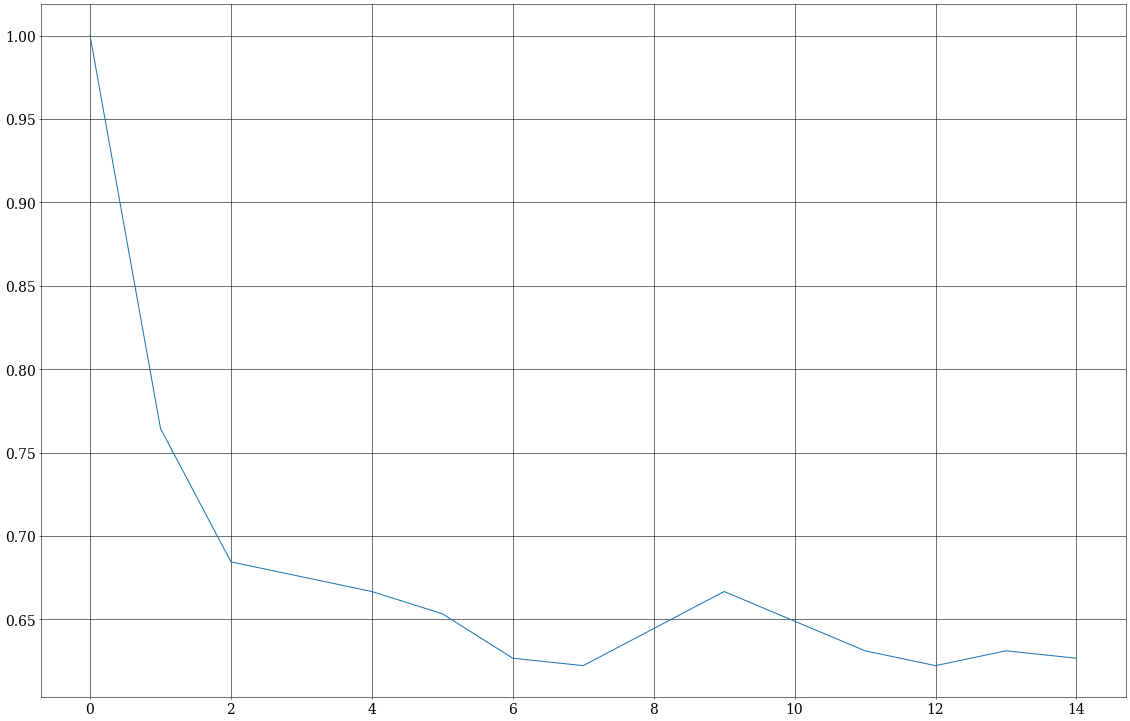

In [24]:
plt.plot(cor(S))
plt.show()

In [25]:
L = 30

nequilibrio = 1_000
npromedio = 500

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso

r_vals = np.arange(l)  # dominio de la funcion de correlacion


def fitcor(r, a, xi):  # funcion con la que vamos a ajustar
    return a * np.exp(-r / xi)


S = np.ones((L, L), dtype=int)

print("Longitud de correlacion:")

for T in tqdm([1.5, 2.3, 3], desc="Temperaturas"):

    beta = 1 / T

    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in tqdm(range(nequilibrio), desc="Termalizando"):
        S, dm, de = metropolis(S, prob)

    m[0] = np.mean(S)
    c[:, 0] = cor(S)

    for n in tqdm(range(1, npromedio), desc="Midiendo"):
        S, dm, dc = metropolis2(S, prob)
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    parametros, covarianza = curve_fit(fitcor, r_vals, correlacion)
    # (la funcion curve_fit devuelve el mejor valor de los parametros
    # y tambien la covarianza, que no vamos a usar)

    print("T={} => {}".format(T, parametros[1]))

    plt.plot(r_vals, fitcor(r_vals, parametros[0], parametros[1]), label="T={}".format(T))

plt.xlabel("r")
plt.ylabel("funcion de correlacion")
plt.legend()
plt.show()

Longitud de correlacion:


Temperaturas:   0%|          | 0/3 [00:00<?, ?it/s]

Termalizando:   0%|          | 0/1000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/499 [00:00<?, ?it/s]

SystemError: CPUDispatcher(<function metropolis2 at 0x74947e726c00>) returned a result with an exception set